# CONFLUENCE Tutorial 1a — Point-Scale Workflow (Paradise SNOTEL)

## Introduction

This notebook demonstrates the point-scale modeling workflow in **CONFLUENCE**, a framework for reproducible and modular computational hydrology. At the point scale, we simulate vertical energy and water fluxes at a single site, independent of routing or lateral flow, to isolate and evaluate model process representations.

Here, we focus on the **Paradise SNOTEL station (ID 602)**, located at 1,630 m elevation in Washington’s Cascade Range. This site represents a transitional snow climate and provides long-term observations of snow water equivalent (SWE) and soil moisture across multiple depths. By reproducing the observed seasonal snow and soil moisture dynamics, this tutorial demonstrates how CONFLUENCE structures a controlled, transparent, and fully reproducible point-scale experiment.

Through this example, you will see how configuration-driven workflows manage experiment setup, geospatial definition, input data preprocessing, model instantiation, and performance evaluation—building a foundation for more complex distributed modeling studies later in the series.


# Step 1 — Configuration (pick or generate)

We begin by selecting (or programmatically generating) a single configuration file that fully specifies the experiment. This keeps the workflow reproducible and makes initialization a one-liner.


In [1]:
# Step 1 — Create a site-specific configuration for the Paradise SNOTEL example

from pathlib import Path
import yaml

# Path to the default template configuration
config_template = Path("../../0_config_files/config_template.yaml")

# Load the base configuration
with open(config_template, "r") as f:
    config = yaml.safe_load(f)

# === Modify key entries for the Paradise SNOTEL point-scale case ===

# Define code directory — ensures relative paths resolve correctly
config["CONFLUENCE_CODE_DIR"] = str(Path("../../").resolve())

# Define data directory — location of required input and observational data
#config["CONFLUENCE_DATA_DIR"] = str(Path("/path/to/CONFLUENCE_data").resolve())

# Restrict the spatial domain to a single site using latitude/longitude bounds
# This ensures domain setup treats it as a point-scale (non-routed) experiment
config["DOMAIN_DEFINITION_METHOD"] = "point"
config["DOMAIN_DISCRETIZATION"] = "GRUs"
config["BOUNDING_BOX_COORDS"] = "46.781/-121.751/46.779/-121.749"
config["POUR_POINT_COORDS"] = "46.78/-121.75"

# Enable automatic download of SNOTEL data for this station
config["DOWNLOAD_SNOTEL"] = True

# Specify model and forcing dataset used in this example
config["HYDROLOGICAL_MODEL"] = "SUMMA"     # SUMMA is the process-based model used here
config["FORCING_DATASET"] = "ERA5"         # ERA5 reanalysis for meteorological inputs

# Define the temporal extent of the experiment
config["EXPERIMENT_TIME_START"] = "2000-01-01 01:00"
config["EXPERIMENT_TIME_END"] = "2002-12-31 23:00"
config['CALIBRATION_PERIOD'] = "2000-10-01, 2001-09-30"
config['EVALUATION_PERIOD'] = "2001-10-01, 2002-09-30"
config['SPINUP_PERIOD'] = "2000-01-01, 2000-09-30"

# Assign a descriptive domain name and experiment ID
config["DOMAIN_NAME"] = "paradise"
config["EXPERIMENT_ID"] = "run_1"

# MAF paths and settings - if you have access to MAF data stored on DRAC, Access Anvil or U calgary ARC 
config['DATATOOL_DATASET_ROOT'] = '/path/to/meteorological-data/'           # Path to datatool datasets root directory
config['GISTOOL_DATASET_ROOT'] = '/path/to/geospatial-data/'                # Path to gistool datasets root directory
config['TOOL_CACHE'] = '/path/to/cache/dir'                                 # Path to gistool cache directory
config['CLUSTER_JSON']: '/path/to/cluster.json'                             # Path to cluster json config
config['SNOW_DATA_SOURCE'] = 'SNOTEL'                                # Snow data source: SNOTEL, manual
config['SNOW_STATIONS'] = '679'                                        # Snow station IDs
config['ISMN_NETWORK'] = 'SCAN'                                        # ISMN network name
config['ISMN_STATIONS'] = '679'                                        # ISMN station IDs

# Optimisation settings
config['OPTIMISATION_TARGET'] = 'swe'
config['PARAMS_TO_CALIBRATE'] = 'tempCritRain,tempRangeTimestep,frozenPrecipMultip,albedoMax,albedoMinWinter,albedoDecayRate,constSnowDen,mw_exp,k_snow,z0Snow'
config['ITERATIVE_OPTIMIZATION_ALGORITHM'] = 'DDS'
config['OPTIMIZATION_METRIC'] = 'RMSE'
config['CALIBRATION_TIMESTEP'] = 'daily'  



# === Save the customized configuration ===
out_config = Path("../../0_config_files/config_paradise.yaml")
with open(out_config, "w") as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

print(f"✅ New configuration written to: {out_config}")

✅ New configuration written to: ../../0_config_files/config_paradise.yaml


## Step 1b — Initialize CONFLUENCE

With the configuration prepared, we now initialize **CONFLUENCE**.  
This step reads the configuration file, sets up the project directory, and registers all workflow managers (data, domain, model, and evaluation).  


In [2]:
# Step 1b — Initialize CONFLUENCE
import os, sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from CONFLUENCE import CONFLUENCE  # adjust if your import path differs

config_path = "../../0_config_files/config_paradise.yaml"
confluence = CONFLUENCE(config_path)

print("✅ CONFLUENCE initialized successfully.")
print(f"Configuration loaded from: {config_path}")

2025-11-04 13:51:21 ● CONFLUENCE Logging Initialized
2025-11-04 13:51:21 ● Domain: paradise
2025-11-04 13:51:21 ● Experiment ID: run_1
2025-11-04 13:51:21 ● Log Level: INFO
2025-11-04 13:51:21 ● Log File: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/_workLog_paradise/confluence_general_paradise_20251104_135121.log
2025-11-04 13:51:21 ● Configuration logged to: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/_workLog_paradise/config_paradise_20251104_135121.yaml
2025-11-04 13:51:21 ● CONFLUENCE initialized with config: ../../0_config_files/config_paradise.yaml
2025-11-04 13:51:21 ● Creating point domain shapefile from bounding box coordinates
2025-11-04 13:51:21 ● Point domain shapefile created successfully: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/river_basins/paradise_riverBasins_point.shp
2025-11-04 13:51:21 ● Bounding box: lat_min=46.779, lat_max=46.781, lon_min=-121.751, lon_max=-121.749
2025-11-

## Step 1c — Project structure setup

We now create the standardized project directory and a pour-point feature for the site.  
This anchors the experiment in a clear, reproducible file layout and records the site location for downstream domain and data steps.


In [3]:
# Step 1c — Project structure setup

from pathlib import Path

# 1) Create the standardized project layout (logs, config link, data/output folders, etc.)
project_dir = confluence.managers['project'].setup_project()

# 2) Create a pour-point feature (the site reference geometry for point-scale workflows)
pour_point_path = confluence.managers['project'].create_pour_point()

print("✅ Project structure created.")
print(f"Project root: {project_dir}")
print(f"Pour point:   {pour_point_path}")

# 3) Brief top-level directory preview
print("\nTop-level structure:")
for p in sorted(Path(project_dir).iterdir()):
    if p.is_dir():
        print(f"├── {p.name}")

2025-11-04 13:51:21 ● Setting up project for domain: paradise
2025-11-04 13:51:21 ● Project directory created at: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise
2025-11-04 13:51:21 ● Pour point shapefile created successfully: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/pour_point/paradise_pourPoint.shp
✅ Project structure created.
Project root: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise
Pour point:   /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/pour_point/paradise_pourPoint.shp

Top-level structure:
├── _workLog_paradise
├── attributes
├── forcing
├── observations
├── optimisation
├── plots
├── settings
├── shapefiles
├── simulations


## Step 2 — Domain definition (point-scale GRU)

For the Paradise SNOTEL example, the domain is a **single GRU** representing the site footprint.  
This keeps the workflow strictly point-scale (no routing), aligning the geometry with the pour point created in Step 1.

### Step 2a — Geospatial attribute acquisition - **Only available through MAF supported HPCs**

We first acquire site attributes (elevation, land cover, soils, etc.).  
These are model-agnostic inputs used to parameterize vertical energy and water balance at the site.

- If you are using the downloaded example data. Copy the attributes, forcing and observation directories into the newly created domain directory from step 1c

In [4]:
# Step 2a — Acquire attributes (model-agnostic)
# If you are using MAF supported HPC, uncomment the below line
#confluence.managers['data'].acquire_attributes()
print("✅ Attribute acquisition complete")

✅ Attribute acquisition complete


### Step 2b — Domain definition (point-scale)

With attributes prepared, we define a point-scale domain consistent with the pour point.  
For this example, the domain is a minimal footprint around the Paradise SNOTEL site.

In [5]:
# Step 2b — Define the point-scale domain
watershed_path = confluence.managers['domain'].define_domain()
print("✅ Domain definition complete")
print(f"Domain file: {watershed_path}")

2025-11-04 13:51:21 ● Domain definition workflow starting with: point
2025-11-04 13:51:21 ● Point domain shapefile already exists: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/river_basins/paradise_riverBasins_point.shp
2025-11-04 13:51:21 ● Domain definition completed using method: point
2025-11-04 13:51:21 ● Domain map saved to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/plots/domain/domain_map.png
2025-11-04 13:51:21 ● Domain definition workflow finished
✅ Domain definition complete
Domain file: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/river_basins/paradise_riverBasins_point.shp


### Step 2c — Discretization (required even for 1 GRU = 1 HRU)

Discretization writes the **catchment HRU shapefile** and related artifacts required by downstream steps.  
For the point-scale case we set `DOMAIN_DISCRETIZATION: GRUs`, which creates a **single HRU** identical to the GRU while still generating the standardized outputs.


In [6]:
# Step 2c — Discretization (GRUs → HRUs 1:1, but files are still created)
hru_path = confluence.managers['domain'].discretize_domain()
print("✅ Domain discretization complete")
print(f"HRU file: {hru_path}")

2025-11-04 13:51:21 ● Discretizing domain using method: GRUs
2025-11-04 13:51:21 ● Starting domain discretization using attributes: ['GRUs']
Step 1/2: Running single attribute discretization method
2025-11-04 13:51:21 ● config domain name paradise
2025-11-04 13:51:21 ● Calculating mean elevation for each HRU
2025-11-04 13:51:21 ● DEM CRS: EPSG:4326
2025-11-04 13:51:21 ● Shapefile CRS: EPSG:4326
2025-11-04 13:51:21 ● CRS match - no reprojection needed
2025-11-04 13:51:21 ● Successfully calculated elevation statistics for 1 HRUs
2025-11-04 13:51:21 ● Calculated centroids in WGS84: lat range 46.780000 to 46.780000, lon range -121.750000 to -121.750000
2025-11-04 13:51:21 ● GRUs saved as HRUs to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/catchment/paradise_HRUs_GRUs.shp
2025-11-04 13:51:22 ● HRU plot saved to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/plots/catchment/paradise_HRUs_as_GRUs.png
Step 2/2: Sorting catchment shape

## Step 2d — Verification & inspection (Paradise SNOTEL)

We verify that discretization produced the expected shapefiles in the standardized locations, then plot a minimal GRU–HRU overlay.

**Expected files**
- `domain_dir/shapefiles/river_basins/paradise_riverBasins_point.shp` (GRU)
- `domain_dir/shapefiles/catchment/paradise_HRUs_GRUs.shp` (HRU)


✅ GRU file found: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/river_basins/paradise_riverBasins_point.shp
✅ HRU file found: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/catchment/paradise_HRUs_GRUs.shp


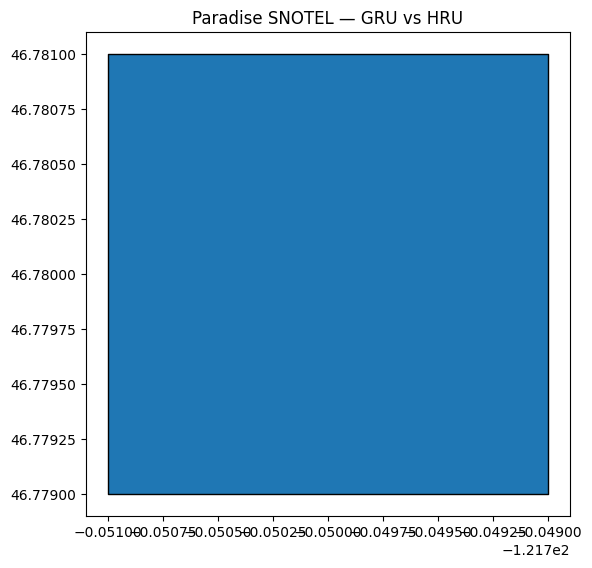

In [7]:
# Step 2d — Verify domain outputs and inspect geometry

from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import yaml

# 1) Read config to get data dir and domain name
with open("../../0_config_files/config_paradise.yaml") as f:
    cfg = yaml.safe_load(f)

data_dir   = Path(cfg["CONFLUENCE_DATA_DIR"])
domain_dir = data_dir / f"domain_{cfg['DOMAIN_NAME']}"
shp_dir    = domain_dir / "shapefiles"

# 2) Explicit expected shapefiles for Paradise
gru_fp = shp_dir / "river_basins" / "paradise_riverBasins_point.shp"
hru_fp = shp_dir / "catchment"     / "paradise_HRUs_GRUs.shp"

# 3) Verify presence
for label, path in [("GRU", gru_fp), ("HRU", hru_fp)]:
    if not path.exists():
        raise FileNotFoundError(f"❌ Expected {label} file not found: {path}")
    print(f"✅ {label} file found: {path}")

# 4) Minimal overlay plot
gru = gpd.read_file(gru_fp)
hru = gpd.read_file(hru_fp)
if hru.crs != gru.crs:
    hru = hru.to_crs(gru.crs)

ax = gru.plot(figsize=(6, 6))
hru.plot(ax=ax, facecolor="none")
ax.set_title("Paradise SNOTEL — GRU vs HRU")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

# Step 3 — Input preprocessing (model-agnostic)

We prepare inputs in three small moves:
1) acquire **meteorological forcings**,  
2) process **observations** (SNOTEL), and  
3) run **model-agnostic preprocessing** to standardize time steps, variables, and units for downstream use.

### Step 3a — Acquire meteorological forcings (ERA5)

Downloads/subsets the forcings for the Paradise domain.


In [8]:
# Step 3a — Forcings
# If you are using MAF supported HPC, uncomment the below line
# confluence.managers['data'].acquire_forcings()
print("✅ Forcing data acquisition complete")


✅ Forcing data acquisition complete


### Step 3b — Process observations (SNOTEL)

Parses site observations (e.g., SWE, soil moisture), applies basic QA/QC, and stores standardized outputs.


In [9]:
# Step 3b — Observations
# If you are using MAF supported HPC, uncomment the below line
#confluence.managers['data'].process_observed_data()
print("✅ Observational data processing complete")

✅ Observational data processing complete


### Step 3c — Model-agnostic preprocessing

Standardizes variable names, units, and time steps (and fills required diagnostics) so multiple models can consume the same inputs consistently.

In [10]:
# Step 3c — Model-agnostic preprocessing
confluence.managers['data'].run_model_agnostic_preprocessing()
print("✅ Model-agnostic preprocessing complete")

2025-11-04 13:51:22 ● Starting model-agnostic preprocessing
2025-11-04 13:51:22 ● Running geospatial statistics
2025-11-04 13:51:22 ● Starting geospatial statistics calculation
2025-11-04 13:51:22 ● Existing soil statistics file /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/catchment_intersection/with_soilgrids/catchment_with_soilclass.shp does not contain expected data. Recalculating.
2025-11-04 13:51:22 ● Calculating soil statistics
2025-11-04 13:51:22 ● Soil raster CRS: EPSG:4326
2025-11-04 13:51:22 ● Catchment shapefile CRS: EPSG:4326
2025-11-04 13:51:22 ● CRS match - no reprojection needed
2025-11-04 13:51:22 ● Soil statistics saved to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/catchment_intersection/with_soilgrids/catchment_with_soilclass.shp
2025-11-04 13:51:22 ● Land statistics already calculated: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/catchment_intersection/with_l

### Step 3d — Quick verification

We confirm the expected folders exist and contain files:

- `forcing/raw_data/`
- `forcing/basin_averaged_data/`
- `observations/snow/{raw,processed}/`
- `observations/soil_moisture/{raw,processed}/`


In [11]:
from pathlib import Path
import yaml

# Derive paths from the config (no hard-coding)
with open("../../0_config_files/config_paradise.yaml") as f:
    cfg = yaml.safe_load(f)

data_dir   = Path(cfg["CONFLUENCE_DATA_DIR"])
domain_dir = data_dir / f"domain_{cfg['DOMAIN_NAME']}"

targets = {
    "forcing/raw_data":                  domain_dir / "forcing" / "raw_data",
    "forcing/basin_averaged_data":       domain_dir / "forcing" / "basin_averaged_data",
    "observations/snow/raw":             domain_dir / "observations" / "snow" / "swe" / "raw",
    "observations/snow/processed":       domain_dir / "observations" / "snow" / "swe" / "processed",
    "observations/soil_moisture/raw":    domain_dir / "observations" / "soil_moisture" / "ismn" / "raw",
    "observations/soil_moisture/processed": domain_dir / "observations" / "soil_moisture" / "ismn" / "processed",
}

def count_files(p: Path) -> int:
    return sum(1 for x in p.iterdir() if x.is_file()) if p.exists() else 0

for label, path in targets.items():
    exists = path.exists()
    n = count_files(path)
    status = "✅" if exists and n > 0 else ("⚠️ empty" if exists else "❌ missing")
    suffix = f"({n} files)" if exists else ""
    print(f"{status} {label}  {suffix}")

✅ forcing/raw_data  (37 files)
✅ forcing/basin_averaged_data  (36 files)
✅ observations/snow/raw  (1 files)
✅ observations/snow/processed  (1 files)
✅ observations/soil_moisture/raw  (2 files)
✅ observations/soil_moisture/processed  (1 files)


# Step 4 — Model-specific preprocessing & model run (SUMMA)

We now convert the model-agnostic inputs into **SUMMA-ready inputs**, then instantiate and run the model for the Paradise point-scale case.


### Step 4a — SUMMA-specific preprocessing

Creates the SUMMA input bundle (metadata, parameter tables, forcing links) from the standardized inputs.


In [12]:
# Step 4a — SUMMA-specific preprocessing
confluence.managers['model'].preprocess_models()
print("✅ Model-specific preprocessing complete")

2025-11-04 13:51:22 ● Starting model-specific preprocessing
2025-11-04 13:51:22 ● Starting SUMMA spatial preprocessing
2025-11-04 13:51:22 ● Starting memory-efficient temperature lapse rate and data step application
2025-11-04 13:51:22 ● Loading topology data...
2025-11-04 13:51:22 ● Loaded topology data: 1 rows, 0.00 MB
2025-11-04 13:51:22 ● Found 36 forcing files to process
2025-11-04 13:51:22 ● Pre-calculating lapse rate corrections...
2025-11-04 13:51:22 ● Prepared lapse corrections for 1 HRUs
2025-11-04 13:51:22 ● Processing files in batches of 36
2025-11-04 13:51:24 ● Completed processing of 36 ERA5 forcing files with temperature lapsing
2025-11-04 13:51:24 ● Copying SUMMA base settings
2025-11-04 13:51:24 ● SUMMA base settings copied to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/settings/SUMMA
2025-11-04 13:51:24 ● Creating SUMMA file manager
2025-11-04 13:51:24 ● SUMMA file manager created at /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domai

## Step 4b — Instantiate & run the model

Instantiates the model using the prepared inputs and executes the point-scale simulation.


In [13]:
# Step 4b — Instantiate & run SUMMA
print(f"Running {confluence.config['HYDROLOGICAL_MODEL']} for point-scale simulation…")
confluence.managers['model'].run_models()
print("✅ Point-scale model run complete")

Running SUMMA for point-scale simulation…
2025-11-04 13:51:24 ● Starting model runs
2025-11-04 13:51:24 ● Running model: SUMMA
2025-11-04 13:51:24 ● Starting SUMMA run
2025-11-04 13:51:51 ● SUMMA run completed successfully
✅ Point-scale model run complete


### Step 4c - Quick verification

Print where SUMMA inputs and run outputs were written (paths are derived from the configuration).


In [14]:
from pathlib import Path
import yaml

with open("../../0_config_files/config_paradise.yaml") as f:
    cfg = yaml.safe_load(f)

data_dir   = Path(cfg["CONFLUENCE_DATA_DIR"])
domain_dir = data_dir / f"domain_{cfg['DOMAIN_NAME']}"

# Common locations used by the model manager
summa_in   = domain_dir / "forcing" / "SUMMA_input"
results    = domain_dir / "simulations" / cfg['EXPERIMENT_ID'] / 'SUMMA' 

print("SUMMA input dir:", summa_in if summa_in.exists() else "(not found)")
print("Results dir:",    results if results.exists()    else "(not found)")

SUMMA input dir: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/SUMMA_input
Results dir: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/simulations/run_1/SUMMA


Opened: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/simulations/run_dds/SUMMA/run_dds_opt_run_1_day.nc
SWE sim range: 2001-01-01 00:00:00 → 2001-09-30 00:00:00
SWE obs range: 1980-10-01 00:00:00 → 2024-03-25 00:00:00
SWE overlap days: 273
Detected obs SWE units: cm (×10.0)
SWE metrics: {'RMSE': 84.056, 'Bias': 65.775, 'r': 0.997}


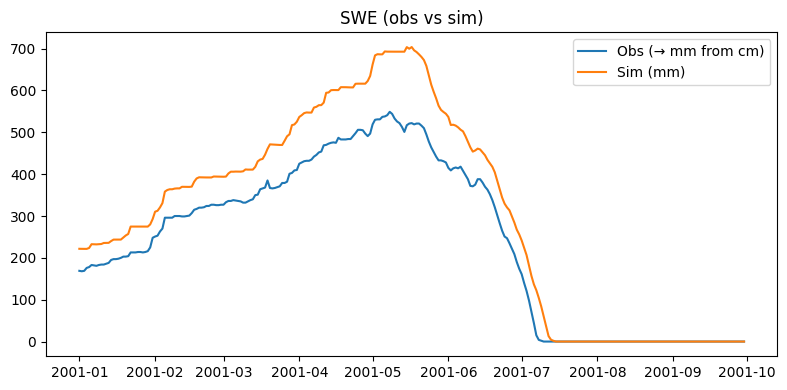

In [15]:
# Step 4c — SWE only (obs vs sim) with robust NetCDF open + unit auto-detect

from pathlib import Path
import yaml, pandas as pd, numpy as np, xarray as xr
import matplotlib.pyplot as plt
import re

# --- Paths from config ---
with open("../../0_config_files/config_paradise.yaml") as f:
    cfg = yaml.safe_load(f)
data_dir   = Path(cfg["CONFLUENCE_DATA_DIR"])
domain_dir = data_dir / f"domain_{cfg['DOMAIN_NAME']}"

# Find a daily SUMMA output (e.g., *_day.nc) under the domain folder
nc_files = list(domain_dir.rglob("*_day.nc"))
if not nc_files:
    # fallback: any .nc under results
    nc_files = list((domain_dir / "simulations" / cfg['EXPERIMENT_ID'] / "SUMMA").rglob("_day.nc"))
if not nc_files:
    raise FileNotFoundError(f"No netCDF files found under {domain_dir}")
nc_path = nc_files[0]

def open_dataset_safe(path: Path) -> xr.Dataset:
    if not path.exists():
        raise FileNotFoundError(f"Path does not exist: {path}")
    if path.is_dir() or path.suffix.lower() == ".zarr":
        # Zarr store
        return xr.open_zarr(path)
    errs = []
    for eng in ("netcdf4", "scipy"):
        try:
            return xr.open_dataset(path, engine=eng)
        except Exception as e:
            errs.append(f"{eng}: {e}")
    raise ValueError(f"Could not open {path} with engines netcdf4/scipy.\n" + "\n".join(errs))

# --- Helpers ---
def rmse(a, b): 
    d = (a - b).to_numpy(dtype=float)
    return float(np.sqrt(np.nanmean(d**2)))

def bias(a, b):
    return float((a - b).mean())

def first_numeric_col(df):
    cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    return cols[0] if cols else None

def reduce_to_time_series(da: xr.DataArray) -> pd.Series:
    if "time" not in da.dims:
        if "time" in da.coords:
            da = da.swap_dims({list(da.dims)[0]: "time"})
        else:
            raise ValueError("DataArray has no 'time' dimension or coordinate.")
    # pick first layer if present; average any spatial dims (hru/gru)
    for d in [d for d in da.dims if d != "time"]:
        if re.search("layer|soil", d, re.I):
            da = da.isel({d: 0})
        else:
            da = da.mean(d)
    s = da.to_series()
    s.index = pd.to_datetime(s.index)
    return s.sort_index()

def read_obs_csv(path: Path):
    df = pd.read_csv(path, index_col=0)
    if not isinstance(df.index, pd.DatetimeIndex):
        df = pd.read_csv(path)
        date_col = next(c for c in df.columns if re.search("date|time", str(c), re.I))
        df[date_col] = pd.to_datetime(df[date_col].astype(str).str.strip(), dayfirst=True, errors="raise")
        df = df.set_index(date_col)
    df = df.sort_index()
    col = first_numeric_col(df)
    if not col:
        raise ValueError(f"No numeric SWE column found in {path}")
    return df[col].astype(float), str(col)

def align(a, b):
    idx = a.index.intersection(b.index)
    return a.loc[idx].astype(float), b.loc[idx].astype(float)

# --- Open dataset robustly & handle spinup safely ---
ds = open_dataset_safe(nc_path)

# robust time extraction
time_vals = ds.get("time")
if time_vals is None or np.size(time_vals) == 0:
    raise ValueError("Dataset has no usable 'time' coordinate.")
time_pd = pd.to_datetime(np.array(time_vals.values), errors="coerce")
if pd.isna(time_pd).all():
    # cftime fallback
    time_pd = pd.to_datetime([f"{t.year:04d}-{t.month:02d}-{t.day:02d}" for t in time_vals.values])
start_year = int(time_pd.min().year) + 1

ds_eval = ds.sel(time=slice(f"{start_year}-01-01", None))
if ds_eval.sizes.get("time", 0) == 0:
    ds_eval = ds  # if skipping a year empties it, use full record

# SWE (simulation) — expected in mm
swe_var_candidates = ["scalarSWE", "scalarSnowWaterEquivalent", "SWE"]
swe_var = next((v for v in swe_var_candidates if v in ds_eval.data_vars), None)
if not swe_var:
    raise KeyError(f"SWE variable not found. Tried: {swe_var_candidates}")
swe_sim = reduce_to_time_series(ds_eval[swe_var])

# --- Load SWE observations (processed; unknown units) ---
swe_obs_csv1 = domain_dir / "observations" / "snow" / "processed" / f"{cfg['DOMAIN_NAME']}_swe_processed.csv"
swe_obs_csv2 = domain_dir / "observations" / "snow" / "swe" / "processed" / f"{cfg['DOMAIN_NAME']}_swe_processed.csv"
swe_obs_csv  = swe_obs_csv1 if swe_obs_csv1.exists() else swe_obs_csv2
swe_obs_raw, swe_obs_col = read_obs_csv(swe_obs_csv)

# --- Unit auto-detection: assume sim is mm; try mm/cm/in for obs ---
candidates = {"mm": 1.0, "cm": 10.0, "in": 25.4}
scores, aligned_examples = {}, {}
for unit, factor in candidates.items():
    obs_scaled = swe_obs_raw * factor
    sim_a, obs_a = align(swe_sim, obs_scaled)
    if len(sim_a) == 0:
        scores[unit] = np.inf
    else:
        scores[unit] = rmse(sim_a, obs_a)
        aligned_examples[unit] = (sim_a, obs_a)

best_unit = min(scores, key=scores.get)
scale = candidates[best_unit]
if not np.isfinite(scores[best_unit]):
    raise ValueError("No overlapping dates between SWE sim and obs.")
swe_sim_a, swe_obs_a = aligned_examples[best_unit]

# --- Metrics & diagnostics ---
def corr(a, b): return float(pd.Series(a).corr(pd.Series(b)))

swe_metrics = dict(RMSE=rmse(swe_sim_a, swe_obs_a),
                   Bias=bias(swe_sim_a, swe_obs_a),
                   r=corr(swe_sim_a, swe_obs_a))

print(f"Opened: {nc_path}")
print(f"SWE sim range: {swe_sim.index.min()} → {swe_sim.index.max()}")
print(f"SWE obs range: {swe_obs_raw.index.min()} → {swe_obs_raw.index.max()}")
print(f"SWE overlap days: {len(swe_sim_a)}")
print(f"Detected obs SWE units: {best_unit} (×{scale})")
print("SWE metrics:", {k: round(v,3) for k,v in swe_metrics.items()})

# --- Plot ---
plt.figure(figsize=(8,4))
plt.plot(swe_obs_a.index, swe_obs_a.values, label=f"Obs (→ mm from {best_unit})")
plt.plot(swe_sim_a.index, swe_sim_a.values, label="Sim (mm)")
plt.title("SWE (obs vs sim)")
plt.legend()
plt.tight_layout()
plt.show()

ds.close()


# Step 5 — Calibration (SUMMA, Differential Evolution)

We enable **iterative calibration** for SUMMA, set the **calibration/evaluation periods**, choose **parameters**, and pick a **single objective** (KGE).  
CONFLUENCE exposes a one-liner to run calibration once config is set.


## Step 5a — Minimal config (what matters)

Add/confirm these in `config_paradise.yaml`:

```yaml
# Enable iterative calibration with DE, use KGE on the calibration window
OPTIMISATION_METHODS: [iteration]
ITERATIVE_OPTIMIZATION_ALGORITHM: DE      # DE, DDS, PSO, SCE-UA, NSGA-II
OPTIMIZATION_METRIC: KGE                  # KGE, NSE, RMSE, MAE, KGEp

# Parameters to calibrate (point-scale set)
PARAMS_TO_CALIBRATE: tempCritRain,k_soil,vGn_n,theta_sat


In [ ]:
# Step 5b — Run calibration (DE + KGE)

results_file = confluence.managers['optimization'].calibrate_model()  
print("Calibration results file:", results_file)

2025-11-04 13:51:52 ● Starting model calibration
2025-11-04 13:51:52 ● Using DDS optimization
2025-11-04 13:51:52 ● Using spinup + calibration period: 2000-01-01 01:00 to 2001-09-30 23:00
2025-11-04 13:51:52 ● Calibration will use daily timestep
2025-11-04 13:51:52 ● Initialized SnowTarget for SWE calibration
2025-11-04 13:51:52 ● Starting DDS optimization for swe calibration
2025-11-04 13:51:52 ● Target metric: RMSE
2025-11-04 13:51:52 ● Max iterations: 100
2025-11-04 13:51:52 ● Running DDS algorithm
2025-11-04 13:51:52 ● Initializing DDS with single solution
2025-11-04 13:51:52 ● Evaluating initial solution...
